In [1]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as stats
import utils

# Prep Traffic Data

In [2]:
df = utils.load_csv('../*2019.csv')

  0%|          | 0/12 [00:00<?, ?it/s]/home/smr1020/anaconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
 42%|████▏     | 5/12 [00:03<00:04,  1.42it/s]/home/smr1020/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


In [3]:
df = df.dropna()
df['DataAsOf'] = pd.to_datetime(df['DataAsOf'])

In [10]:
df['Speed_norm'] = 0
for group in df.groupby('Id'):
    df_tem = group[1]
    df_tem['Speed_norm'] = stats.zscore(df_tem['Speed'])
    df['Speed_norm'][df.index.isin(df_tem.index)] = df_tem['Speed_norm']

<ipython-input-10-a9b855d8c37e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tem['Speed_norm'] = stats.zscore(df_tem['Speed'])
<ipython-input-10-a9b855d8c37e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Speed_norm'][df.index.isin(df_tem.index)] = df_tem['Speed_norm']
<ipython-input-10-a9b855d8c37e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [ ]:
df.to_csv('traffic_data_clean.csv')

# Prep Weather Data

In [7]:
col_names = ['year','month','day','hour','temp','dpt','mslp','winddir','wndspd','sky','prcp1','prcp6']
df_weather = pd.read_csv('725053-94728-2019',sep='\s+',names=col_names,na_values=[-9999])

df_weather['time'] = pd.to_datetime(df_weather[['year','month','day','hour']])
df_weather = df_weather[['time','temp','dpt','mslp','sky','wndspd','prcp1']]
df_weather = df_weather.set_index('time')

In [8]:
keep = []

for name in ['temp','dpt','mslp','prcp1','sky','wndspd']:
    
    fraction_exists = (len(df_weather[~df_weather[name].isna()])/len(df_weather))*100
    
    print(f'{name}: {fraction_exists}')
    
    if fraction_exists > 90:
        keep.append(name)

temp: 99.62285714285714
dpt: 99.57714285714286
mslp: 96.56
prcp1: 97.29142857142857
sky: 59.12
wndspd: 75.63428571428571


In [9]:
df_weather = df_weather.dropna()
df_weather = df_weather[keep].resample('5min').pad()

In [22]:
df = pd.read_csv('traffic_data_clean.csv')
df['DataAsOf'] = pd.to_datetime(df['DataAsOf'])
df = df[['Id','Speed_norm','DataAsOf']]
df.head()

,Id,Speed_norm,DataAsOf
0,1,-0.776763,2019-02-01 01:58:11
1,106,-1.511565,2019-02-01 01:58:11
2,110,0.327143,2019-02-01 01:58:04
3,119,-2.081642,2019-02-01 01:58:03
4,124,-1.117963,2019-02-01 01:58:03


In [28]:
def plot_traffic_speed(df,start,end,figsize = (10,3),ticks='1D'):
    
    '''plots and resamples'''

    plt.figure(dpi=300,figsize=figsize)
    dates = pd.date_range(start=start,end=end,freq=ticks)

    mask = (df['DataAsOf'] > pd.to_datetime(start)) & (df['DataAsOf'] <= pd.to_datetime(end))

    df_filtered = df[mask]

    df_list = []


    for group in df_filtered.groupby('Id'):
        df_tem = group[1].set_index('DataAsOf')
        plt.plot(df_tem.index,df_tem['Speed_norm'],alpha=0.05,color='k')
        plt.xticks(ticks = dates,labels = dates,rotation=45,ha='right',size=5)

        df_i = df_tem.rename(columns = {'Speed_norm':df_tem['Id'][0]})[df_tem['Id'][0]]
        df_i = df_i.resample('5min').mean()

        df_list.append(df_i)

    df_rs = pd.concat(df_list, axis=1, ignore_index=False)
    df_rs.median(axis=1).plot(c='tab:orange')
    
    return df_rs

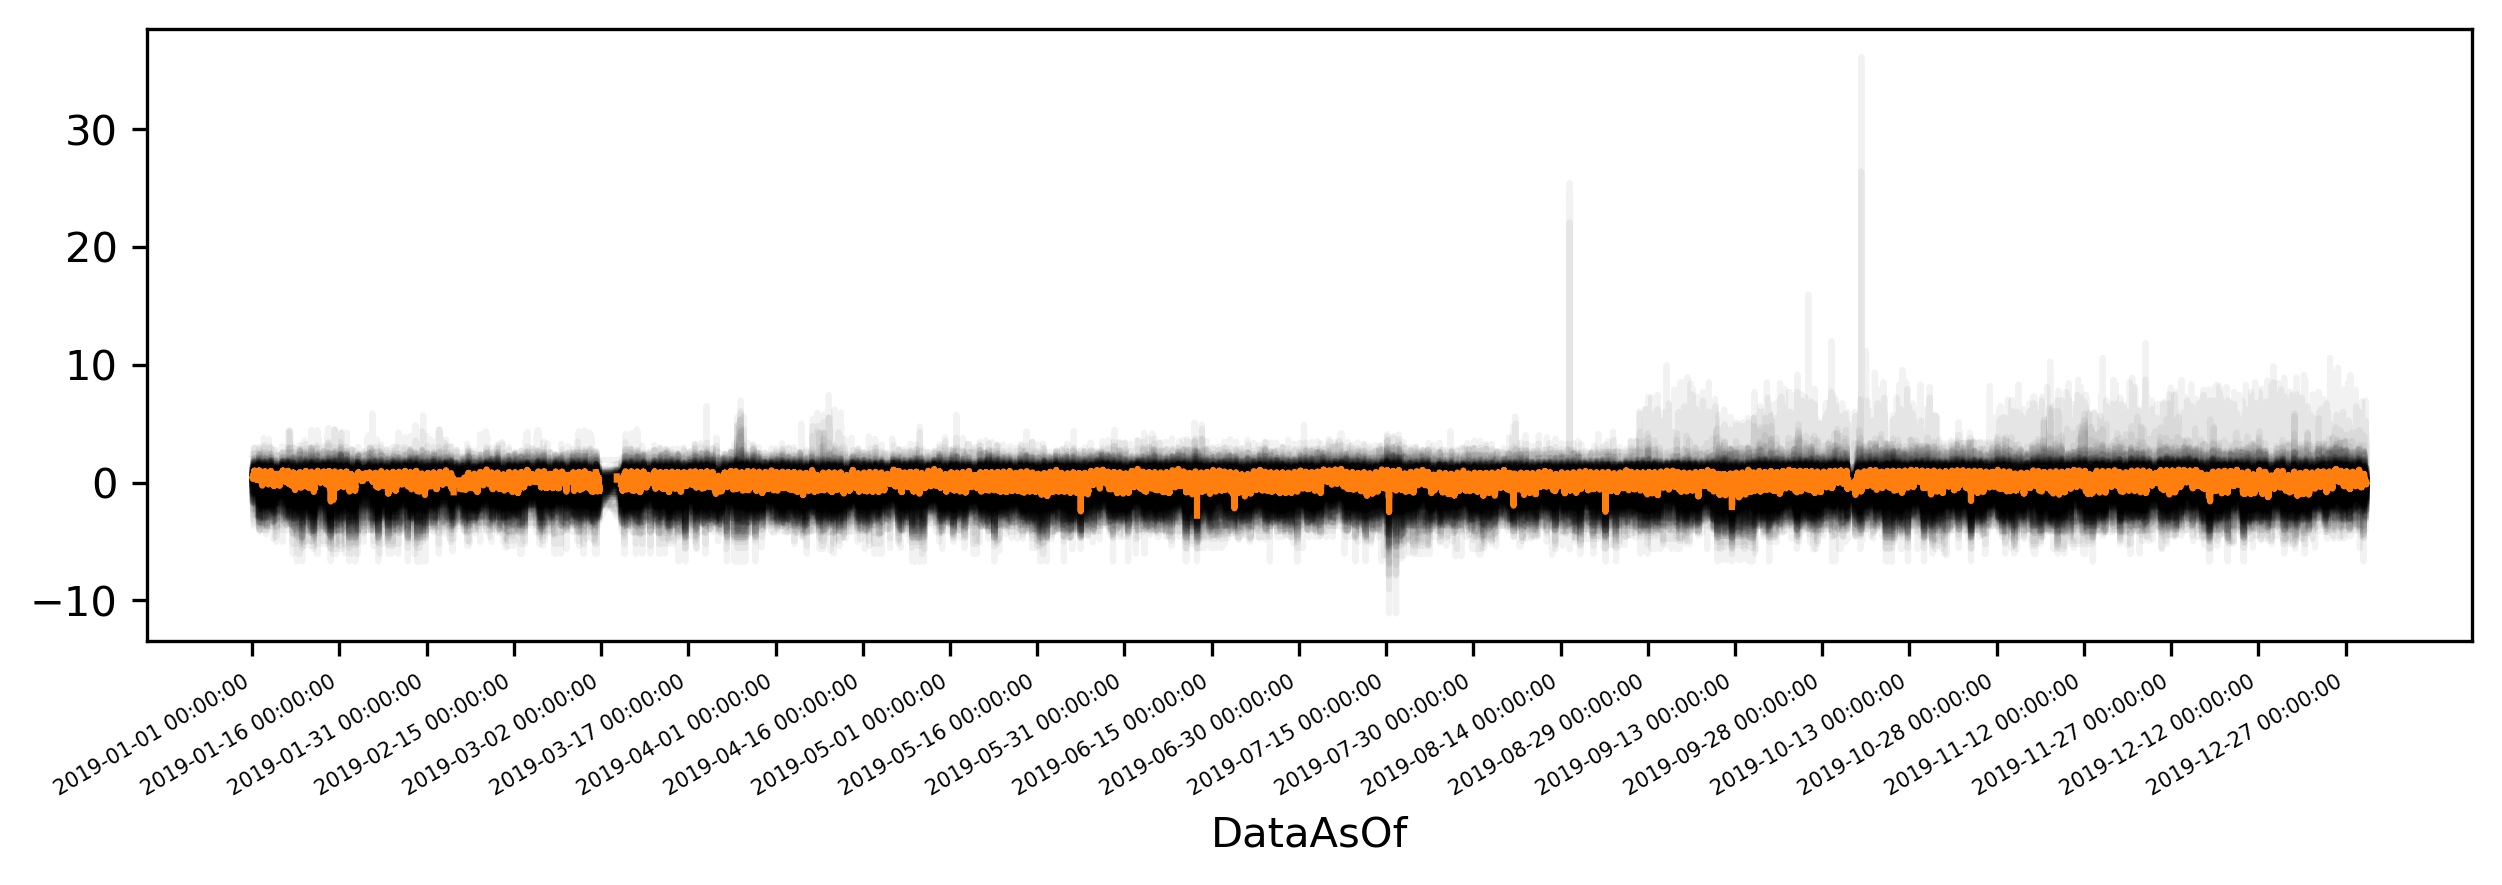

In [33]:
start = '2019-01-01'
end = '2019-12-31'

df_rs = plot_traffic_speed(df,start,end,figsize = (10,3),ticks='15D')

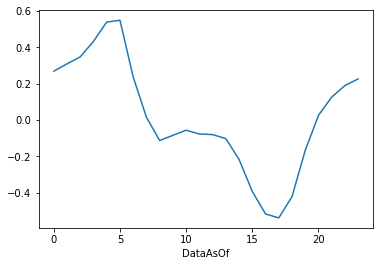

In [34]:
df_rs.groupby(df_rs.index.hour).mean().mean(axis=1).plot()

In [35]:
normal = df_rs.groupby(df_rs.index.hour).mean().median(axis=1)

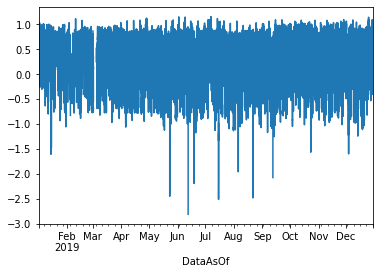

In [44]:
df_rs.median(axis=1).plot()

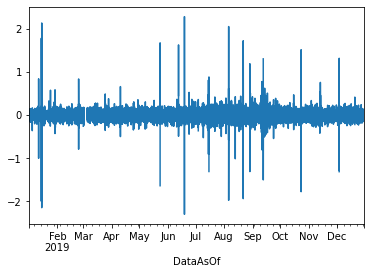

In [51]:
df_rs.median(axis=1).diff().plot()

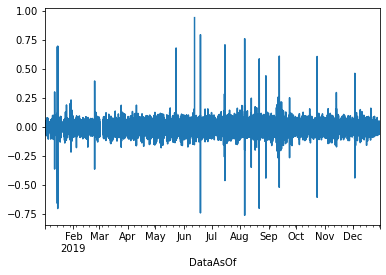

In [58]:
df_rs.median(axis=1).diff().rolling(3).mean().plot()

In [ ]:
df_rs.std(axis=1).plot(xlim=('2019-09-12','2019-09-13'))

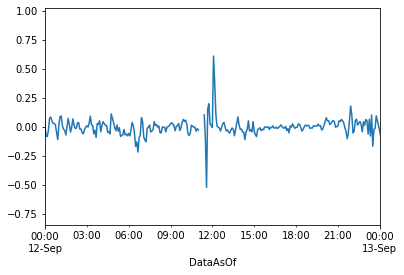

In [57]:
df_rs.median(axis=1).diff().rolling(3).mean().plot(xlim=('2019-09-12','2019-09-13'))